In [17]:
%run setup.py
# %config IPython.matplotlib.backend = "retina"

# Lower and Upper limits Sharma11

In [18]:
path=work_path+"sample/sharpness/sharma16/"
relations = ["dnu", "numax", "mass", "radius"]
names = ["$\Delta\\nu$", "$\\nu_{\\rm max}$", "$M$", "$R$"]
lnames = ["\Dnu{}", "\\numax{}", "$M$", "$R$"]
llim, ellim, ulim, eulim = [np.zeros(4) for i in range(4)]
for i in range(4):
    data = np.load(path+relations[i]+"/llim/data.npy",allow_pickle=True).tolist()
    llim[i], ellim[i] = data['para_fit'][1], data['e_para_fit'][1]
    data = np.load(path+relations[i]+"/ulim/data.npy",allow_pickle=True).tolist()
    ulim[i], eulim[i] = data['para_fit'][1], data['e_para_fit'][1]


In [19]:
# fig = plt.figure(figsize=mnras_size())
# axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
# ind = np.arange(4)
# axes[0].errorbar(ind-0.1, ulim*100, yerr=eulim*100, color=blue, fmt="s", capsize=2, label="Corrected $\\Delta\\nu$")
# axes[0].errorbar(ind-0.1, llim*100, yerr=ellim*100, color=orange, fmt="s", capsize=2)
# axes[0].errorbar(ind+0.1, ulim1*100, yerr=eulim1*100, color=blue, fmt="^", capsize=2, label="Scaling $\\Delta\\nu$")
# axes[0].errorbar(ind+0.1, llim1*100, yerr=ellim1*100, color=orange, fmt="^", capsize=2)

# axes[0].set_xticks(ind)
# axes[0].set_xticklabels(names)
# axes[0].set_ylabel("$\\sigma$ (\%)")
# axes[0].legend()
# plt.tight_layout()
# plt.savefig(overleaf_path+'limits.pdf')

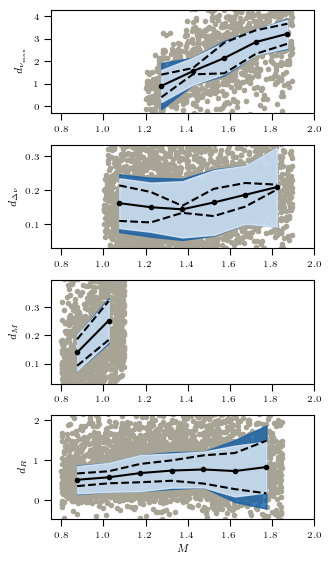

In [43]:
rootpath = "/Users/yaguang/Onedrive/Work/nike/"
import numpy as np 
import matplotlib
import sys
sys.path.append(rootpath) 
from lib.histdist import model6, distfit, distance_to_edge, reduce_samples
from lib.wrapper import sharpness_fit_perturb_llim_mcmc, sharpness_fit_perturb_ulim_mcmc#sharpness_fit_rescale_mcmc
import os

diagrams = ['tnu', 'tnu', 'mr', 'mr']
distances = ['horizontal', 'vertical', 'horizontal', 'vertical']
variables = ['numax', 'dnu', 'mass', 'radius']
variables_latex = ['\\nu_{\\rm max}', '\Delta\\nu', 'M', 'R']
mass_bounds = [np.arange(1.2, 2.0, 0.15),
                np.arange(1.0, 2.0, 0.15),
                np.arange(0.8, 1.2, 0.15),
                np.arange(0.8, 1.9, 0.15)]

fig, axes = plt.subplots(figsize=mnras_size(ratio=1.7), nrows=4, ncols=1, squeeze=False)
axes = axes.reshape(-1)

for i in range(4):
    # fdnu corrected sharma+2016
    obsdir = rootpath+"sample/yu/"
    moddir = rootpath+"sample/padova/"

    diagram, distance, var, varl = diagrams[i], distances[i], variables[i], variables_latex[i]

    # read in unperturbed data sample
    obs = np.load(obsdir+"yu18.npy", allow_pickle=True).tolist()
    pdv = np.load(moddir+"padova.npy", allow_pickle=True).tolist()

    # We only test a subset of stars. 
    # For the rest, there seems to be a disagreement between Galaxia and Kepler.
    idx = (obs["mass"]<=1.9) & (obs["mass"]>=0.8)
    for key in obs.keys():
        obs[key] = obs[key][idx]

    idx = (pdv["mass"]<=1.9) & (pdv["mass"]>=0.8)
    for key in pdv.keys():
        pdv[key] = pdv[key][idx]       


    # read in edges
    if diagram == 'tnu':
        edges_obs = np.load(obsdir+"tnu_edge_samples.npy")
        tck_obs, tp_obs = np.load(obsdir+"nike_spline_tck.npy", allow_pickle=True)
        edges_pdv = np.load(moddir+"tnu_edge_samples.npy")
        tck_pdv, tp_pdv = np.load(moddir+"nike_spline_tck.npy", allow_pickle=True)

        if distance == 'horizontal': # numax
            # to exclude those points which lies below the edge (so no horizontal distance).
            idx = obs["dnu"]>=np.min(edges_obs[:,1])
            for key in obs.keys():
                obs[key] = obs[key][idx]
            idx = pdv["dnu"]>=np.min(edges_pdv[:,1])
            for key in pdv.keys():
                pdv[key] = pdv[key][idx]
        if distance == 'vertical': # dnu
            # to exclude those points which lies left to the edge (so no vertical distance).
            idx = obs["numax"]>=np.min(edges_obs[:,0])
            for key in obs.keys():
                obs[key] = obs[key][idx]
            idx = pdv["numax"]>=np.min(edges_pdv[:,0])
            for key in pdv.keys():
                pdv[key] = pdv[key][idx]

        xobs, yobs = obs["numax"], obs["dnu"]
        e_xobs, e_yobs = obs["e_numax"]/obs["numax"], obs["e_dnu"]/obs["dnu"]
        xpdv, ypdv = pdv["numax"], pdv["dnu"]

    if diagram == 'mr':
        edges_obs = np.load(obsdir+"mr_edge_samples.npy")
        tck_obs, tp_obs = np.load(obsdir+"mr_spline_tck.npy", allow_pickle=True)
        edges_pdv = np.load(moddir+"mr_edge_samples.npy")
        tck_pdv, tp_pdv = np.load(moddir+"mr_spline_tck.npy", allow_pickle=True)

        if distance == 'horizontal': # mass
            # to exclude those points which lies below the edge (so no horizontal distance).
            idx = obs["radius"] <= np.max(edges_obs[:,1])
            for key in obs.keys():
                obs[key] = obs[key][idx]   
            idx = pdv["radius"] <= np.max(edges_obs[:,1])
            for key in pdv.keys():
                pdv[key] = pdv[key][idx]

        if distance == 'vertical': # radius
            # nothing to exclude
            pass

        xobs, yobs = obs["mass"], obs["radius"]
        e_xobs, e_yobs = obs["e_mass"]/obs["mass"], obs["e_radius"]/obs["radius"]
        xpdv, ypdv = pdv["mass"], pdv["radius"]

    hist_model = model6()

    # calculate Kepler distance
    _, _, _, ridx = distance_to_edge(xobs, yobs, edges_obs[:,0], edges_obs[:,1], tck_obs, tp_obs, 
                                  diagram=diagram, distance=distance, return_idx=True)
    m = obs['mass'][ridx]
    
    
    t = mass_bounds[i]
    masses = (t[:-1]+t[1:])/2.0
    Nbin = len(masses)
    zvalue_name = "mass"
    
    ulims, llims, sigmas, ymeds = [np.zeros(Nbin) for j in range(4)]
    
    for ibin in range(Nbin):
        idx = (m>=t[ibin]) & (m<=t[ibin+1])
        x = m[idx]
    
        # read in results
        # upper limits
        filepath = rootpath+"sample/sharpness/sharma16/"+var+"_"+zvalue_name+"/ulim/{:0.0f}/".format(ibin)
        data = np.load(filepath+'data.npy',allow_pickle=True).tolist()
        y = data['obj_obs'].dist
        ymeds[ibin] = np.median(y)
        if distance=='horizontal':
            sigmas[ibin] = np.std(e_xobs[ridx][idx]*xobs[ridx][idx])
            obs = xobs[ridx][idx]
        else:
            sigmas[ibin] = np.std(e_yobs[ridx][idx]*yobs[ridx][idx])
            obs = yobs[ridx][idx]

        para_fitmax = np.zeros(2)
        for ipara in range(2):
            n, bins = np.histogram(data['samples'][:,ipara], 80)
            idx = np.where(n == n.max())[0][0]
            para_fitmax[ipara] = bins[idx:idx+1].mean()   
        ulims[ibin] = data['para_fit'][-1] * np.median(obs)#data['para_fit'][-1] * np.median(obs)#

#         if (var=='dnu') & (ibin==5):
#             ulims[ibin] = para_fitmax[-1] * np.median(obs)#

        # lower limits
        filepath = rootpath+"sample/sharpness/sharma16/"+var+"_"+zvalue_name+"/llim/{:0.0f}/".format(ibin)
        data = np.load(filepath+'data.npy',allow_pickle=True).tolist()

        para_fitmax = np.zeros(2)
        for ipara in range(2):
            n, bins = np.histogram(data['samples'][:,ipara], 80)
            idx = np.where(n == n.max())[0][0]
            para_fitmax[ipara] = bins[idx:idx+1].mean()     
        llims[ibin] = para_fitmax[-1] * np.median(obs)#data['para_fit'][-1] * np.median(obs)#

        # plot
        axes[i].scatter(x, y, c=grey, marker='.')

    axes[i].plot(masses, ymeds, 'k.')
    axes[i].plot(masses, ymeds, 'k-')
    axes[i].plot(masses, ymeds+ulims, 'k--')
    axes[i].plot(masses, ymeds-ulims, 'k--')
    axes[i].fill_between(masses, ymeds+sigmas+llims, ymeds-sigmas-llims, 
                         color=blues()[-2], alpha=0.8)
    axes[i].fill_between(masses, ymeds+sigmas, ymeds-sigmas, 
                         color=blues()[0], alpha=0.8)
    axes[i].axis([0.75, 2.0, np.min(ymeds-sigmas-ulims), np.max(ymeds+sigmas+ulims)])
    axes[i].set_ylabel('$d_{'+varl+'}$')
    

axes[-1].set_xlabel('$M$')
plt.tight_layout()
plt.savefig(overleaf_path+'mass.pdf')


In [27]:
tx.shape

(164,)

In [28]:
y.shape

(260,)

In [29]:
m.shape

(1570,)

In [30]:
t

array([1.2 , 1.35, 1.5 , 1.65, 1.8 , 1.95])

In [36]:
ulims

array([0.05189525, 0.04437839, 0.00802957, 0.05245739, 0.0417376 ,
       0.57286819])

In [33]:
y

array([ 4.00235191,  2.28974666,  2.76884432,  3.74378705,  4.64389829,
        2.60794022,  2.53871471,  2.98049392,  3.35499843,  1.09138519,
       -2.84285498,  3.20023788,  2.22402932,  4.05921713, -2.68968626,
        3.76501794,  3.29340839,  1.27512599,  4.87792329,  3.06512176,
        2.00342148,  3.270676  ,  3.80916197,  2.53606551,  2.62536177,
        4.42221051,  2.62899025,  2.77756905,  2.78950982,  1.10415136,
        5.48877673,  2.57469206,  4.78363298,  1.85455349,  2.38619594,
        4.60449271,  4.80271822,  4.71432977,  4.61177487,  5.98808697,
        5.21624234,  4.39305185,  6.44098816,  2.6094831 ,  4.89721066,
        3.93672857, -0.19288674,  2.47527597, -0.40038938,  6.24864606,
        5.90232002,  4.75608757,  3.5409297 ,  2.04140409,  1.53711507,
        2.67559493,  1.41631573,  3.28342148,  3.62405668,  3.17678202,
        2.21338815,  3.25191844,  0.64427049,  3.68736771,  2.53917504,
        2.44160707,  6.08308818,  3.23297645,  1.91531067, -3.36